In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
# import ta
%matplotlib inline

In [2]:
link1 = 'https://en.wikipedia.org/wiki/NIFTY_50'
link2 = 'https://en.wikipedia.org/wiki/NIFTY_Next_50'

Stocks = pd.read_html(link1)[2].Symbol
Next_Stocks = pd.read_html(link2)[3].Symbol

Stocks += '.NS'
Next_Stocks += '.NS'

Stocks.head(5)

0      ADANIENT.NS
1    ADANIPORTS.NS
2    APOLLOHOSP.NS
3    ASIANPAINT.NS
4      AXISBANK.NS
Name: Symbol, dtype: object

In [3]:
Stocks = Stocks.to_list()
Next_Stocks = Next_Stocks.to_list()

Final_Stocks = Stocks + Next_Stocks

In [4]:
Data = yf.download(Final_Stocks, start = '2019-01-01', end = '2023-07-30')['Close']
OpenData = yf.download(Final_Stocks, start = '2019-01-01', end = '2023-07-30')['Open']

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed


# Sample Test

In [83]:
StockData = yf.download(Final_Stocks[0], start = '2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [84]:
StockData['MA_20'] = StockData.Close.rolling(20).mean()
StockData['Vol'] = StockData.Close.rolling(20).std()

# BB : Bollinger Band - Standard deviation above and below the standard moving average
StockData['Upper_BB'] = StockData.MA_20 + (2 * StockData.Vol)
StockData['Lower_BB'] = StockData.MA_20 - (2 * StockData.Vol)

In [85]:
StockData

,Open,High,Low,Close,Adj Close,Volume,MA_20,Vol,Upper_BB,Lower_BB
Date,,,,,,,,,,
2019-01-01,160.899994,162.350006,155.449997,157.250000,155.309723,4726656,NaN,NaN,NaN,NaN
2019-01-02,157.000000,157.850006,152.500000,154.850006,152.939362,2735262,NaN,NaN,NaN,NaN
2019-01-03,154.899994,156.100006,150.300003,152.500000,150.618347,2758876,NaN,NaN,NaN,NaN
2019-01-04,152.100006,154.000000,150.000000,152.550003,150.667725,2777308,NaN,NaN,NaN,NaN
2019-01-07,152.899994,154.449997,150.250000,151.250000,149.383774,2714218,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-21,2588.000000,2655.000000,2580.500000,2639.750000,2639.750000,10479200,2499.522498,55.012063,2609.546623,2389.498372
2023-08-22,2668.850098,2721.000000,2654.100098,2698.050049,2698.050049,10291468,2513.515002,67.428029,2648.371060,2378.658945
2023-08-23,2720.000000,2722.399902,2488.850098,2530.300049,2530.300049,5251316,2516.697510,66.596616,2649.890741,2383.504278


In [86]:
# Window : Look-back period for RSI calculation
StockData['RSI'] = ta.momentum.rsi(StockData.Close, window = 6)

In [87]:
StockData['Signal'] = np.where((StockData['RSI'] < 30) & 
                                 (StockData['Close'] < StockData['Lower_BB']), 'Buy', np.nan)

StockData['Signal'] = np.where((StockData['RSI'] > 70) & 
                                 (StockData['Close'] > StockData['Upper_BB']), 'Sell', StockData['Signal'])

# Buy/Sell Signal for Next Trading Day
StockData['Signal'] = StockData['Signal'].shift()
StockData['Signal'] = StockData['Signal'].fillna(0)

StockData['Signal'] = StockData['Signal'].replace({'nan' : 0})

StockData.dropna(inplace=True)

In [88]:
# Signal is based on the Close of a day and we buy the stock at the Open of the next day
StockData['Signal'] = StockData['Signal'].shift()

In [89]:
StockData['Shifted_Close'] = StockData.Close.shift()

In [93]:
# Ensuring that we Buy before we Sell
Position  = False

BuyDates, SellDates = [], []
BuyPrices, SellPrices = [], []

for index, row in StockData.iterrows():
    if not Position and row['Signal'] == 'Buy':
        BuyDates.append(index)
        BuyPrices.append(row.Open)
        Position = True

    if Position:
        if row['Signal'] == 'Sell' or row.Shifted_Close < 0.90 * BuyPrices[-1]:
            SellDates.append(index)
            SellPrices.append(row.Open)
            Position = False

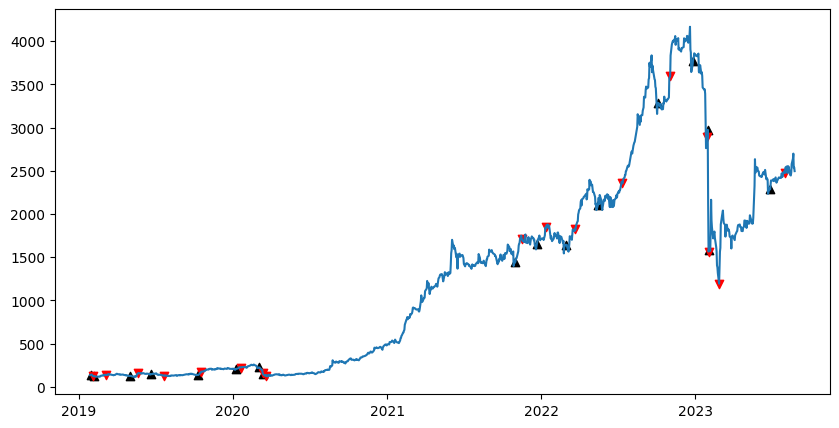

In [94]:
plt.figure(figsize = (10, 5))
plt.plot(StockData.Close)
plt.scatter(StockData.loc[BuyDates].index, 
            StockData.loc[BuyDates].Close, 
            marker = '^', color = 'black')

plt.scatter(StockData.loc[SellDates].index, 
            StockData.loc[SellDates].Close, 
            marker = 'v', color = 'red')

In [95]:
# Calculating the net Profit/Loss based on our Reversion strategy
(pd.Series([((Sell - Buy) / Buy) for Sell, Buy in zip(SellPrices, BuyPrices)]) + 1).prod() - 1


0.08375332037051408

# Testing with NIFTY Data for Last 6 weeks

In [19]:
Stockwise_PL = []

EndBuy = []
EndSell = []

for stock in Final_Stocks:
    CloseStock = Data[stock]
    OpenStock = OpenData[stock]
    
    DataDict = {'Close' : CloseStock, 'Open' : OpenStock}

    StockData = pd.DataFrame(DataDict)
    
    StockData['MA_20'] = StockData.Close.rolling(42).mean()
   
    
    StockData['Vol'] = StockData.Close.rolling(42).std()
    
    

    # BB : Bollinger Band - Standard deviation above and below the standard moving average
    StockData['Upper_BB'] = StockData.MA_20 + (2 * StockData.Vol)
    StockData['Lower_BB'] = StockData.MA_20 - (2 * StockData.Vol)

    # Window : Look-back period for RSI calculation
    StockData['RSI'] = ta.momentum.rsi(StockData.Close, window = 6)

    StockData['Signal'] = np.where((StockData['RSI'] < 30) & 
                                 (StockData['Close'] < StockData['Lower_BB']), 'Buy', np.nan)

    StockData['Signal'] = np.where((StockData['RSI'] > 70) & 
                                    (StockData['Close'] > StockData['Upper_BB']), 'Sell', StockData['Signal'])

    # Buy/Sell Signal for Next Trading Day
    StockData['Signal'] = StockData['Signal'].shift()
    StockData['Signal'] = StockData['Signal'].fillna(0)

    StockData['Signal'] = StockData['Signal'].replace({'nan' : 0})

    StockData.dropna(inplace=True)

    # Signal is based on the Close of a day and we buy the stock at the Open of the next day
    StockData['Signal'] = StockData['Signal'].shift()
    StockData['Shifted_Close'] = StockData.Close.shift()
    
    # print(StockData)
    # Ensuring that we Buy before we Sell
    Position  = False

    BuyDates, SellDates = [], []
    BuyPrices, SellPrices = [], []

    for index, row in StockData.iterrows():
        if not Position and row['Signal'] == 'Buy':
            BuyDates.append(index)
            BuyPrices.append(row.Open)
            Position = True

        if Position:
            if row['Signal'] == 'Sell' or row.Shifted_Close < 0.90 * BuyPrices[-1]:
                SellDates.append(index)
                SellPrices.append(row.Open)
                Position = False

    # print(SellPrices)
    if not Position:
        EndBuy.append(stock)
    else:
        EndSell.append(stock)
    
    # Calculating the net Profit/Loss based on our Reversion strategy
    # Calculating the net Profit/Loss based on our Reversion strategy
    returns = pd.Series([((Sell - Buy) / Buy) for Sell, Buy in zip(SellPrices, BuyPrices)])
    cumulative_returns = returns + 1
    cumulative_return = cumulative_returns.prod() - 1

    # print(cumulative_return)

    Stockwise_PL.append(cumulative_return)

    
    

In [20]:
Final_Results = { 'Stock' : Final_Stocks, 
                  'Profit/Loss' : Stockwise_PL}

Results = pd.DataFrame(Final_Results)

Results

,Stock,Profit/Loss
0,ADANIENT.NS,0.010521
1,ADANIPORTS.NS,0.391683
2,APOLLOHOSP.NS,0.249673
3,ASIANPAINT.NS,0.661034
4,AXISBANK.NS,0.074310
...,...,...
95,TORNTPHARM.NS,1.303515
96,MCDOWELL-N.NS,0.262489
97,VBL.NS,1.064406
98,VEDL.NS,0.362709


In [21]:
Largest10 = Results.nlargest(10, 'Profit/Loss')

TopStocks = Largest10['Stock']

print(TopStocks)

76        INDIGO.NS
57    BAJAJHLDNG.NS
37      RELIANCE.NS
95    TORNTPHARM.NS
83    MUTHOOTFIN.NS
51           ACC.NS
86         PIIND.NS
34          NTPC.NS
97           VBL.NS
36     POWERGRID.NS
Name: Stock, dtype: object


In [22]:
# We find the stocks whose last action at the end of the observation period was Buy or Sell.
# Since we are interested in Buying Stocks, we drop the Stocks whose Position is Sell from our basket 
# We then optimise our purchase of stocks by checking the momentum of the remaining stocks
EndBuy = pd.DataFrame(EndBuy)
EndSell = pd.DataFrame(EndSell)
print(EndSell)


               0
0   EICHERMOT.NS
1  HINDUNILVR.NS
2   KOTAKBANK.NS
3        LTIM.NS
4         UPL.NS
5  ADANITRANS.NS
6         SRF.NS
